In [7]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "/Users/duhameleve/Desktop/M2_SNS/M2SNS/Sante/Github/HAH913E-2024-projet/AX3 Project/Sans titre/data/NoneSmokerCardio.csv"

data = pd.read_csv(file_path)

# Renommer les colonnes pour une meilleure clarté
data.columns = ['Temps', 'X', 'Y', 'Z']


timestamp_column = data.columns[0]
signal_columns = data.columns[1:]   # Colonnes correspondant au X,Y,Z de notre signal enregistré. 

# Conversion de la colonne temps en datatime de panda
data[timestamp_column] = pd.to_datetime(data[timestamp_column], errors='coerce')  # Gestion des données de temps manquantes 

# Calcule de l'intervalle d'échantillonage en secondes 
sampling_interval = (
    pd.to_datetime(data[timestamp_column].iloc[1]) -  
    pd.to_datetime(data[timestamp_column].iloc[0])
).total_seconds()

# Créer une nouvelle colonne "relative_time_minutes" qui représente le temps écoulé depuis le début de la mesure.
data['relative_time_minutes'] = data.index * sampling_interval

# Légende
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']
colors = {'X': 'skyblue', 'Y': 'orange', 'Z': 'lightgreen'}  

In [8]:

#Le capteur n'est pas calibré correctement aisni on applique un offset pour chacun de nos axes.

calibration_offset = {
    'X': -1.62,   # Offset pour l'axe X
    'Y': -0.88,    # Offset pour l'axe Y
    'Z': -1.16    # Offset pour l'axe Z
}
for col, offset in calibration_offset.items():
    data[col] = data[col] - offset

from scipy.signal import butter, filtfilt

# Function to apply a low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter.
    
    Parameters:
        data (array-like): The signal to filter.
        cutoff (float): The cutoff frequency in Hz.
        fs (float): The sampling frequency in Hz.
        order (int): The order of the filter (default is 4).
    
    Returns:
        array-like: The filtered signal.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

fs = 1 / sampling_interval  # Fréquence d'échantillonnage en Hz
cutoff = 2  # Fréquence de coupure en Hz
for col in signal_columns:
    data[col] = lowpass_filter(data[col], cutoff, fs)

   relative_time_minutes  ENMO
0                  0.000   0.0
1                  0.002   0.0
2                  0.004   0.0
3                  0.006   0.0
4                  0.008   0.0


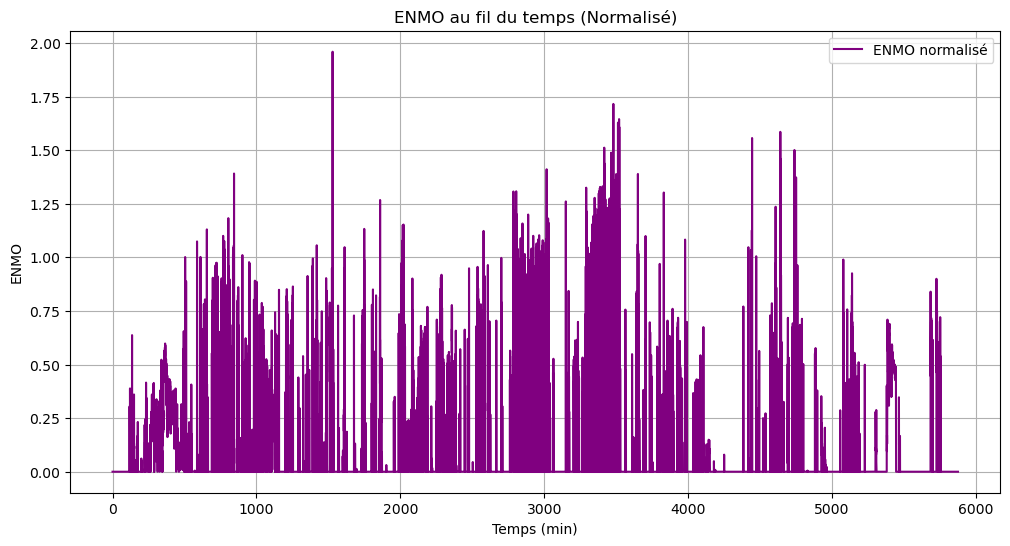

In [9]:
import numpy as np

# Calcul de la norme euclidienne des accélérations (X, Y, Z)
data.loc[:, 'norm'] = np.sqrt(data['X']**2 + data['Y']**2 + data['Z']**2)

# Normalisation : centrer et réduire les données
mean_norm = data['norm'].mean()
std_norm = data['norm'].std()
data.loc[:, 'norm_normalized'] = (data['norm'] - mean_norm) / std_norm

# Calcul de l'ENMO : norme normalisée - 1, et on garde la valeur maximale entre 0 et la norme
data.loc[:, 'ENMO'] = np.maximum(data['norm_normalized'] - 1, 0)

# Affichage des premiers résultats
print(data[['relative_time_minutes', 'ENMO']].head())

# Visualisation de l'ENMO normalisé
plt.figure(figsize=(12, 6))
plt.plot(data['relative_time_minutes'], data['ENMO'], label="ENMO normalisé", color='purple')
plt.title("ENMO au fil du temps (Normalisé)")
plt.xlabel("Temps (min)")
plt.ylabel("ENMO")
plt.legend()
plt.grid(True)
plt.show()

Description des plages d’intensité

Activités faibles ou inactives :
- Généralement avec un ENMO très bas (< 0.1).
Ces moments peuvent être exclus de l’analyse principale pour mieux différencier les efforts modérés et intenses.

Activités modérées (marche rapide) :
- ENMO typique : entre 0.5 et 1.5.
Cela couvre la plage de marche rapide.

Activités intenses (sprint) :
- ENMO typique : entre 1.5 et 3.0.

2. Seuils choisis:

Pour distinguer clairement les trois types d’effort:
	1.	ENMO ≤ 0.5 : Activités faibles ou inactives (à exclure de l’analyse principale).
	2.	0.5 < ENMO ≤ 1.5 : Activités modérées (marche rapide).
	3.	ENMO > 1.5 : Activités intenses (sprint).

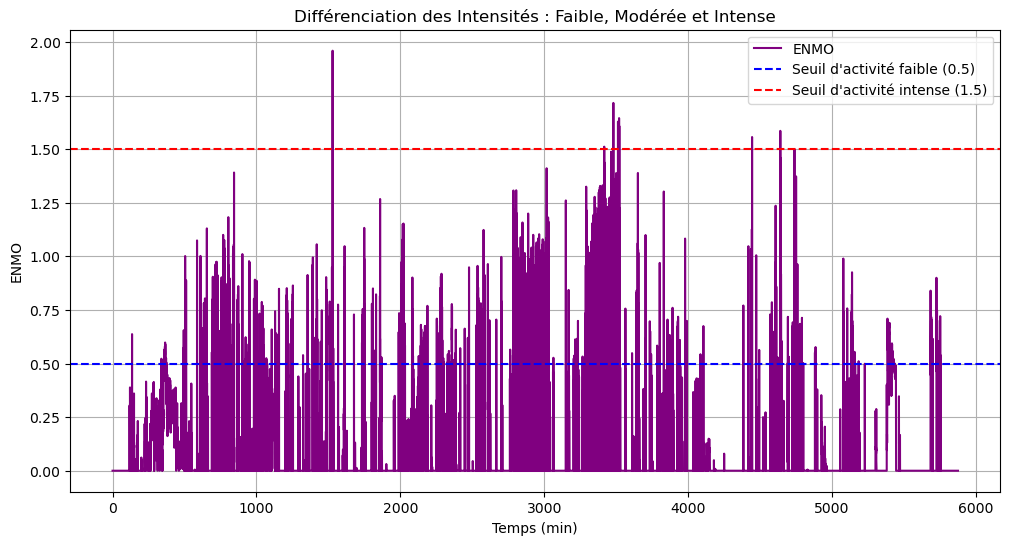

In [10]:
# Définir les seuils pour les intensités
seuil_faible = 0.5
seuil_intense = 1.5

# Classifier les moments d'intensité
moments_faibles = data[data['ENMO'] <= seuil_faible]
moments_moderes = data[(data['ENMO'] > seuil_faible) & (data['ENMO'] <= seuil_intense)]
moments_intenses = data[data['ENMO'] > seuil_intense]

# Visualisation des intensités
plt.figure(figsize=(12, 6))
plt.plot(data['relative_time_minutes'], data['ENMO'], label="ENMO", color='purple')
plt.axhline(y=seuil_faible, color='blue', linestyle='--', label="Seuil d'activité faible (0.5)")
plt.axhline(y=seuil_intense, color='red', linestyle='--', label="Seuil d'activité intense (1.5)")
plt.title("Différenciation des Intensités : Faible, Modérée et Intense")
plt.xlabel("Temps (min)")
plt.ylabel("ENMO")
plt.legend()
plt.grid(True)
plt.show()

# Statistiques descriptives du signal ENMO 

In [11]:
# Statistiques de base
stats = data['ENMO'].describe()
print(stats)

count    2.937599e+06
mean     7.381421e-02
std      1.867790e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.959205e+00
Name: ENMO, dtype: float64


# Analyse des Époques de l'activité 

On regroupe les données en intervalles de temps fixes (par exemple, 1 seconde ou 5 secondes). Pour chaque intervalle (ou époque), on calcule la moyenne des données.

1.	Échantillonnage très fin :

On souhaite créer des intervalles très court, on définit donc une époque de 0.1 seconde, ce qui reflète des variations très rapides. Cela permet de capturer des détails très fins dans les mouvements ou les variations d’accélération. Une grande précision temporelle est utile pour des activités comme le sprint.

Statistiques des époques :
count    118.000000
mean       0.073504
std        0.092183
min        0.000000
25%        0.007586
50%        0.030654
75%        0.117138
max        0.407132
Name: ENMO, dtype: float64


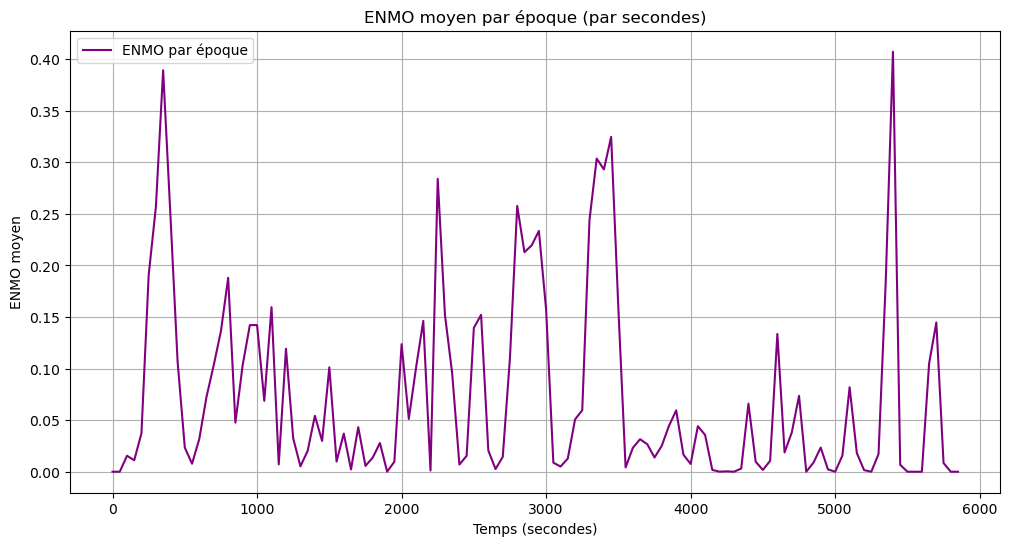

In [12]:
# Regrouper par époques (par exemple, 1 seconde)
epoch_duration = 0.1 / sampling_interval  # Durée d'une époque en secondes
data['epoch_index'] = (data['relative_time_minutes'] // epoch_duration).astype(int)  # Index des époques

# Calculer la moyenne de l'ENMO pour chaque époque
epoch_means = data.groupby('epoch_index')['ENMO'].mean()

# Afficher les résultats
print("Statistiques des époques :")
print(epoch_means.describe())

# Visualiser l'ENMO par époques
plt.figure(figsize=(12, 6))
plt.plot(epoch_means.index * epoch_duration, epoch_means, label="ENMO par époque", color='purple')
plt.title("ENMO moyen par époque (par secondes)")
plt.xlabel("Temps (secondes)")
plt.ylabel("ENMO moyen")
plt.grid(True)
plt.legend()
plt.show()

# Estimation du Rythme cardiaque grâce à l'ENMO 


In [13]:
# Fonction d'estimation du rythme cardiaque en fonction de l'ENMO
def estimate_heart_rate(enmo):
    """
    Estime le rythme cardiaque en fonction de l'ENMO.
    """
    if enmo <= 0.5:
        return 100 + enmo * 40  # Rythme cardiaque pour marche rapide (~100-120 BPM)
    elif enmo <= 1.0:
        return 120 + (enmo - 0.5) * 80  # Transition marche rapide-sprint (~120-160 BPM)
    else:
        return 140 + (enmo - 1.0) * 100  # Sprint intense (~140-180 BPM)

# Appliquer la fonction d'estimation
data['EstimatedHeartRate'] = data['ENMO'].apply(estimate_heart_rate)

# Calculer les statistiques essentielles
min_hr = data['EstimatedHeartRate'].min()
max_hr = data['EstimatedHeartRate'].max()
mean_hr = data['EstimatedHeartRate'].mean()

# Afficher les résultats numériques
print(f"Rythme cardiaque minimum estimé : {min_hr:.2f} BPM")
print(f"Rythme cardiaque maximum estimé : {max_hr:.2f} BPM")
print(f"Rythme cardiaque moyen estimé : {mean_hr:.2f} BPM")

Rythme cardiaque minimum estimé : 100.00 BPM
Rythme cardiaque maximum estimé : 235.92 BPM
Rythme cardiaque moyen estimé : 103.32 BPM


# Statistiques descriptives du signal ENMO après époques

In [14]:
import numpy as np

# Calculer les statistiques de l'ENMO
enmo_mean = data['ENMO'].mean()
enmo_std = data['ENMO'].std()
enmo_max = data['ENMO'].max()
enmo_min = data['ENMO'].min()

# Calculer les caractéristiques de l'intégration ENMO (par époques, si défini)
epoch_mean = epoch_means.mean() if 'epoch_means' in locals() else None
epoch_std = epoch_means.std() if 'epoch_means' in locals() else None

# Résumé des statistiques
statistics = {
    'ENMO_mean': enmo_mean,
    'ENMO_std': enmo_std,
    'ENMO_max': enmo_max,
    'ENMO_min': enmo_min,
    'Epoch_mean': epoch_mean,
    'Epoch_std': epoch_std
}

# Afficher les valeurs numériques
for key, value in statistics.items():
    if value is not None:
        print(f"{key}: {value:.4f}")

ENMO_mean: 0.0738
ENMO_std: 0.1868
ENMO_max: 1.9592
ENMO_min: 0.0000
Epoch_mean: 0.0735
Epoch_std: 0.0922


# Calcule de la quantité d'effort intense fournit au cours de l'enregistrement

In [15]:
# Filtrer les données entre la 1000e et la 3000e seconde
filtered_data = data[(data['relative_time_minutes'] >= 1000) & (data['relative_time_minutes'] <= 3000)]

# Définir le seuil pour l'activité intense
intense_threshold = 1.0

# Nombre total de données filtrées
total_samples_filtered = len(filtered_data)

# Nombre de données au-dessus du seuil dans les données filtrées
intense_samples_filtered = filtered_data[filtered_data['ENMO'] > intense_threshold].shape[0]

# Proportion d'effort intense dans l'intervalle
proportion_intense_filtered = (intense_samples_filtered / total_samples_filtered) * 100

# Résultat
print(f"Proportion d'effort intense (1000-3000 secondes) : {proportion_intense_filtered:.2f}%")

Proportion d'effort intense (1000-3000 secondes) : 0.21%
